In [ ]:
#!pip install --upgrade nltk

In [ ]:
import pandas as pd
import re, numpy as np
import missingno as msno
import folium
from sklearn.cluster import KMeans
from folium.plugins import HeatMap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import shutil
import os
import nltk
from sklearn.impute import KNNImputer
from collections import Counter
from wordcloud import WordCloud
import time
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('./Airbnb_Texas_Rentals.csv')

Cheking dtypes and 7 statistics

In [ ]:
adisplay(df.describe(),df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18259 entries, 0 to 18258
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              18259 non-null  int64  
 1   average_rate_per_night  18231 non-null  object 
 2   bedrooms_count          18256 non-null  object 
 3   city                    18259 non-null  object 
 4   date_of_listing         18259 non-null  object 
 5   description             18257 non-null  object 
 6   latitude                18225 non-null  float64
 7   longitude               18225 non-null  float64
 8   title                   18256 non-null  object 
 9   url                     18259 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.4+ MB


Unnamed: 0      latitude     longitude
count  18259.000000  18225.000000  18225.000000
mean    9130.000000     30.684906    -97.076785
std     5271.063618      1.671008      1.328314
min        1.000000     25.894075   -103.690925
25%     4565.500000     29.693117    -97.817193
50%     9130.000000     30.275907    -97.134467
75%    13694.500000     32.671095    -96.307023
max    18259.000000     35.256299    -93.771139

None

In [ ]:
# Removing sybols and converting dtypes
df['average_rate_per_night'] = (
    df['average_rate_per_night']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

df['bedrooms_count'] = pd.to_numeric(df['bedrooms_count'], errors='coerce').astype('Int8')
df['date_of_listing'] = pd.to_datetime(df['date_of_listing'], errors='coerce')
df.dtypes


Unnamed: 0                         int64
average_rate_per_night           float64
bedrooms_count                      Int8
city                              object
date_of_listing           datetime64[ns]
description                       object
latitude                         float64
longitude                        float64
title                             object
url                               object
dtype: object

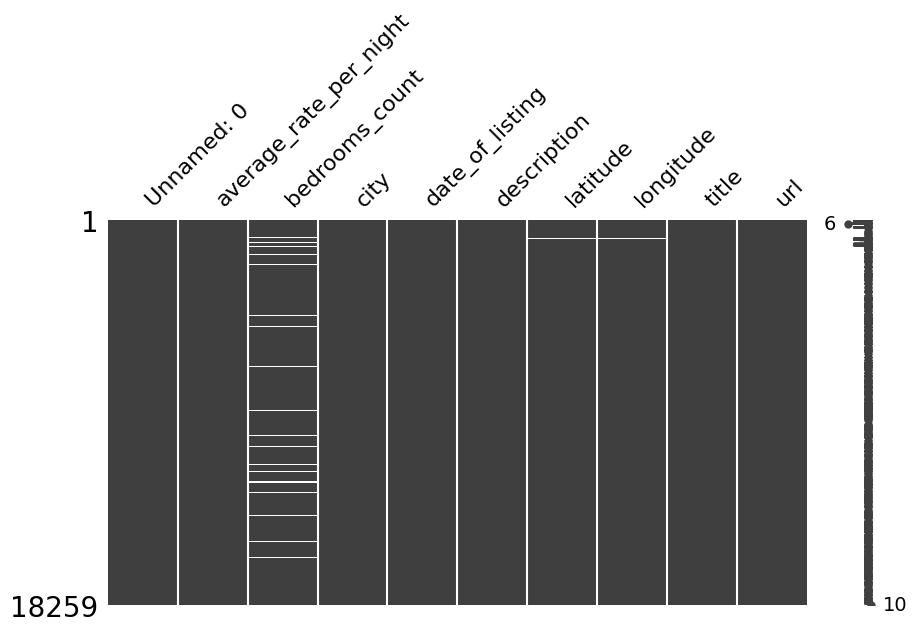

In [ ]:
# Missing value graph
msno.matrix(df,figsize=(10,5));

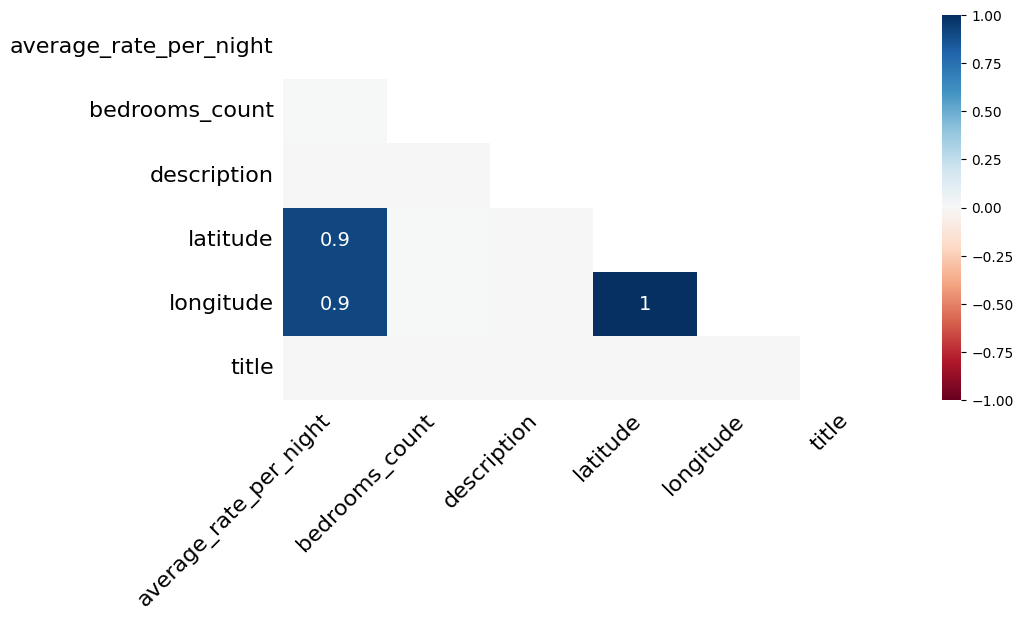

In [ ]:
# correlation between missing values
msno.heatmap(df,figsize=(10,5));

In [ ]:
# filling missing values for longitude and latitude using the same cites long and lat
df['latitude'] = df.groupby('city')['latitude'].transform(lambda x: x.fillna(x.mean()))
df['longitude'] = df.groupby('city')['longitude'].transform(lambda x: x.fillna(x.mean()))

missing_latitude = df['latitude'].isnull().sum()
missing_longitude = df['longitude'].isnull().sum()
missing_latitude, missing_longitude

(1, 1)

In [ ]:
df.isnull().sum()

Unnamed: 0                   0
average_rate_per_night      28
bedrooms_count            1029
city                         0
date_of_listing              0
description                  2
latitude                     1
longitude                    1
title                        3
url                          0
dtype: int64

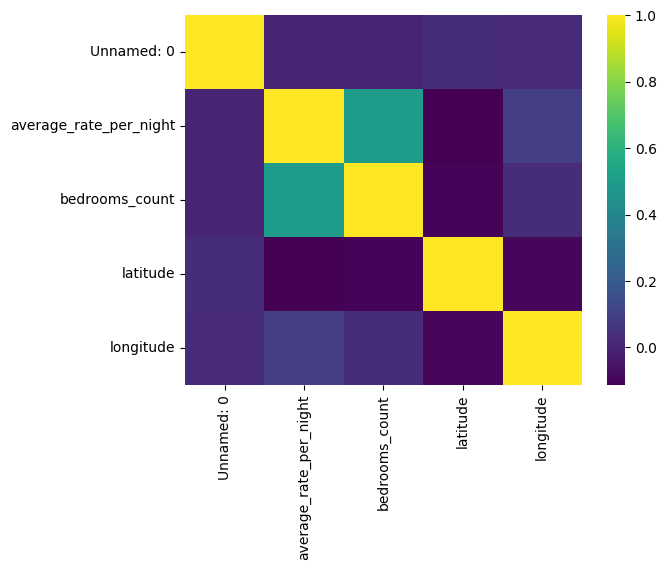

In [ ]:
# Corr matrix
numeric_features = df.select_dtypes(include='number').columns.to_list()

sns.heatmap(df[numeric_features].corr(), cmap='viridis')
plt.show()

Using descipition and nlp procedure filling missing bedroom info

In [ ]:
def extract_bedrooms_fixed(description):
    if pd.isnull(description):
        return np.nan

    patterns = [
        r'(\d+)\s*bedrooms?',
        r'(\d+)\s*beds?',
        r'(\d+)\s*rooms?',
    ]

    word_to_number = {"one": 1, "two": 2, "three": 3, "four": 4, "five": 5}

    for pattern in patterns:
        match = re.search(pattern, description, re.IGNORECASE)
        if match:
            return int(match.group(1))

    for word, num in word_to_number.items():
        if re.search(rf'\b{word}[-\s]?bedroom', description, re.IGNORECASE):
            return num

    if "studio" in description.lower():
        return 1

    return np.nan

df.loc[df['bedrooms_count'].isnull(), 'bedrooms_count'] = df.loc[df['bedrooms_count'].isnull(), 'description'].apply(extract_bedrooms_fixed)

missing_bedrooms_after_fixed = df['bedrooms_count'].isnull().sum()

missing_bedrooms_after_fixed


703

In [ ]:
df_cleaned = df.dropna(subset=[col for col in df.columns if col != 'bedrooms_count'])

knn_features = ['average_rate_per_night', 'latitude', 'longitude', 'bedrooms_count']

knn_imputer = KNNImputer(n_neighbors=5)
df_cleaned[knn_features] = knn_imputer.fit_transform(df_cleaned[knn_features])

df_cleaned['bedrooms_count'] = df_cleaned['bedrooms_count'].round().astype('Int64')
df_cleaned.isnull().sum()

Unnamed: 0                0
average_rate_per_night    0
bedrooms_count            0
city                      0
date_of_listing           0
description               0
latitude                  0
longitude                 0
title                     0
url                       0
dtype: int64

## We can see slight trend here, by the time the average rate increases

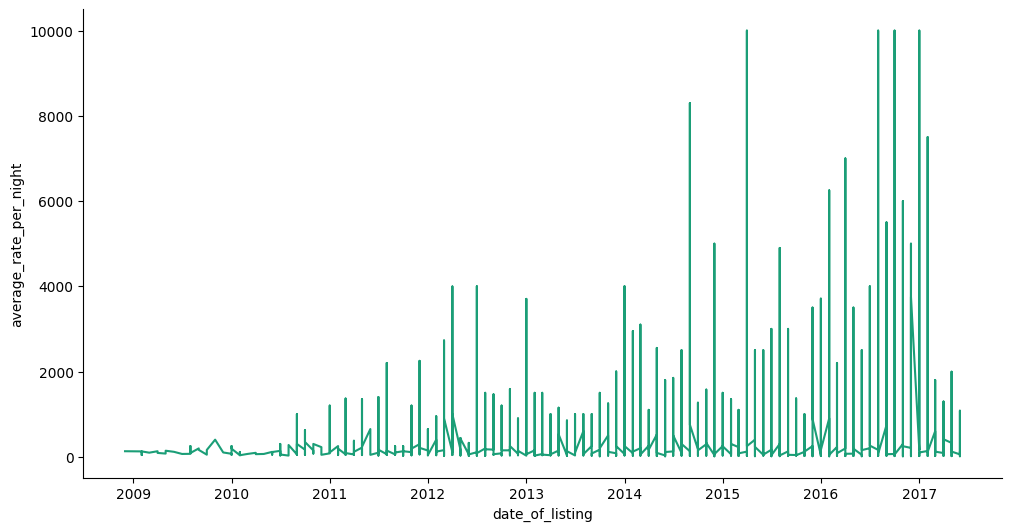

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date_of_listing']
  ys = series['average_rate_per_night']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cleaned.sort_values('date_of_listing', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_of_listing')
_ = plt.ylabel('average_rate_per_night')

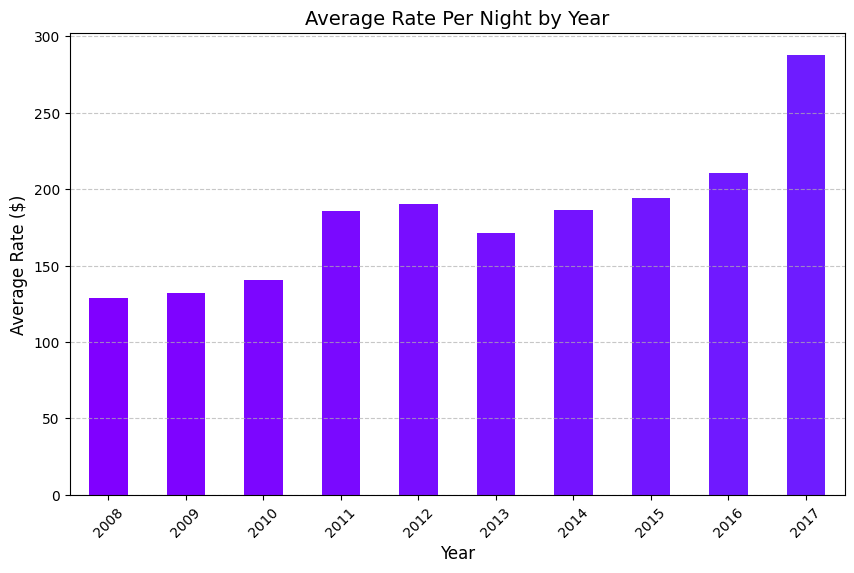

In [ ]:
df_cleaned['year'] = df_cleaned['date_of_listing'].dt.year

avg_rate_per_year = df_cleaned.groupby('year')['average_rate_per_night'].mean()

plt.figure(figsize=(10,6))
avg_rate_per_year.plot(kind='bar', color=plt.cm.rainbow(range(len(avg_rate_per_year))))

plt.title('Average Rate Per Night by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rate ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


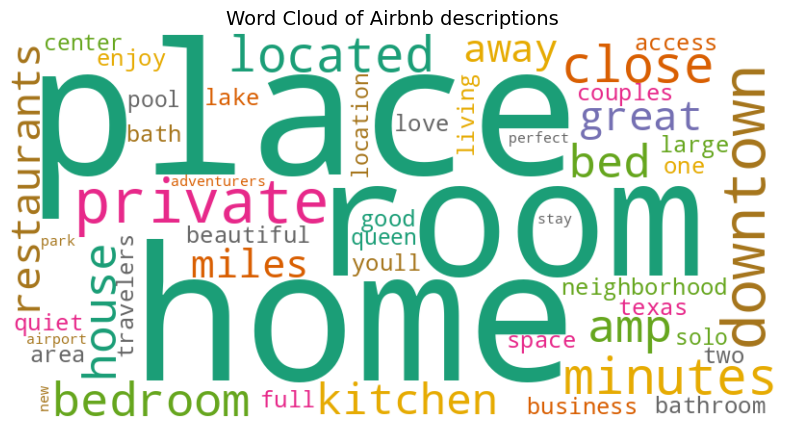

In [ ]:
#Wordcloud using description
nltk.download('stopwords')

nltk_stopwords = set(stopwords.words('english'))

def preprocess_text_nltk(text):
    if pd.isnull(text):
        return ''
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in nltk_stopwords])
    return text

df_cleaned['cleaned_description'] = df_cleaned['description'].apply(preprocess_text_nltk)

all_text_nltk = ' '.join(df_cleaned['cleaned_description'])

word_freq_nltk = Counter(all_text_nltk.split())

wordcloud_nltk = WordCloud(width=800, height=400, background_color="white", colormap="Dark2",
                           max_words=50, random_state=42).generate_from_frequencies(word_freq_nltk)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nltk, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Airbnb descriptions ", fontsize=14)
plt.show()

In [ ]:
df_sample = df_cleaned.copy()

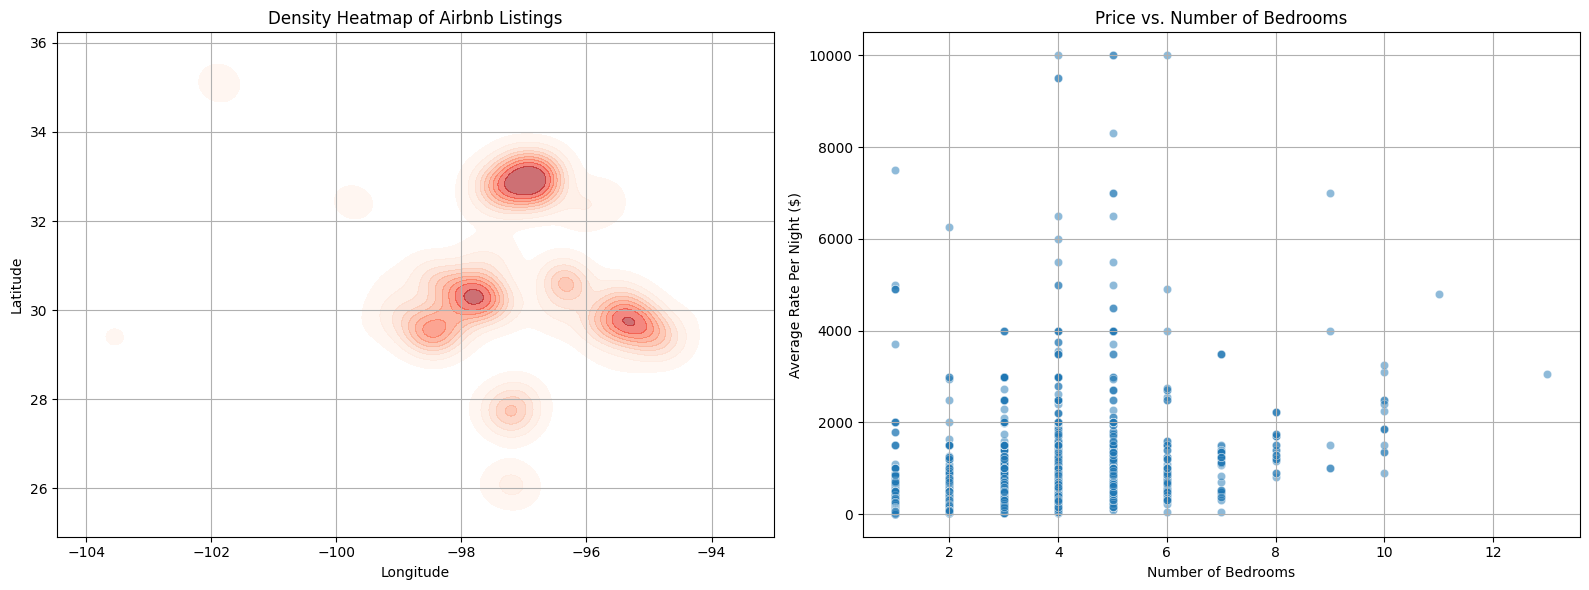

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(x=df_cleaned['longitude'], y=df_cleaned['latitude'], cmap="Reds", fill=True, alpha=0.6, ax=axes[0])
axes[0].set_title("Density Heatmap of Airbnb Listings")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(True)

sns.scatterplot(x=df_cleaned["bedrooms_count"], y=df_cleaned["average_rate_per_night"], alpha=0.5, ax=axes[1])
axes[1].set_title("Price vs. Number of Bedrooms")
axes[1].set_xlabel("Number of Bedrooms")
axes[1].set_ylabel("Average Rate Per Night ($)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

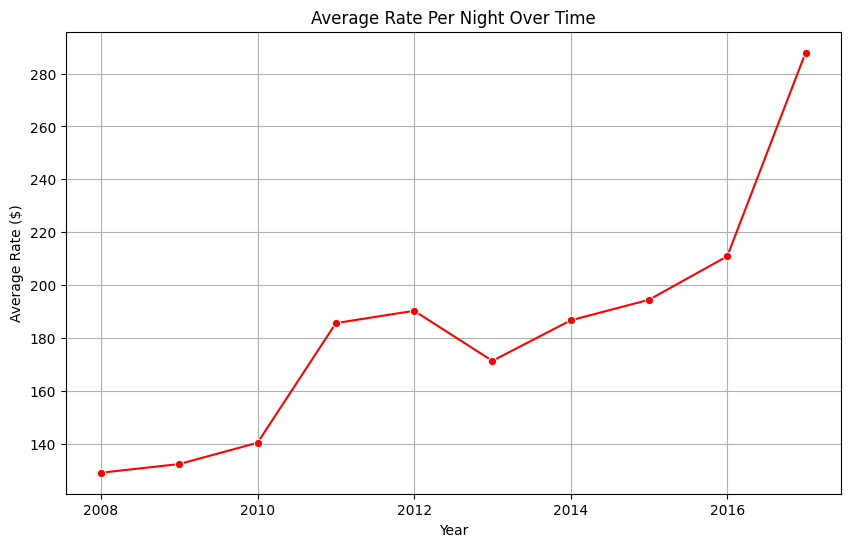

In [ ]:
df_cleaned['year'] = pd.to_datetime(df_cleaned['date_of_listing']).dt.year
yearly_avg_price = df_cleaned.groupby("year")["average_rate_per_night"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_avg_price.index, y=yearly_avg_price.values, marker="o", color='red')
plt.title("Average Rate Per Night Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rate ($)")
plt.grid(True)
plt.show()


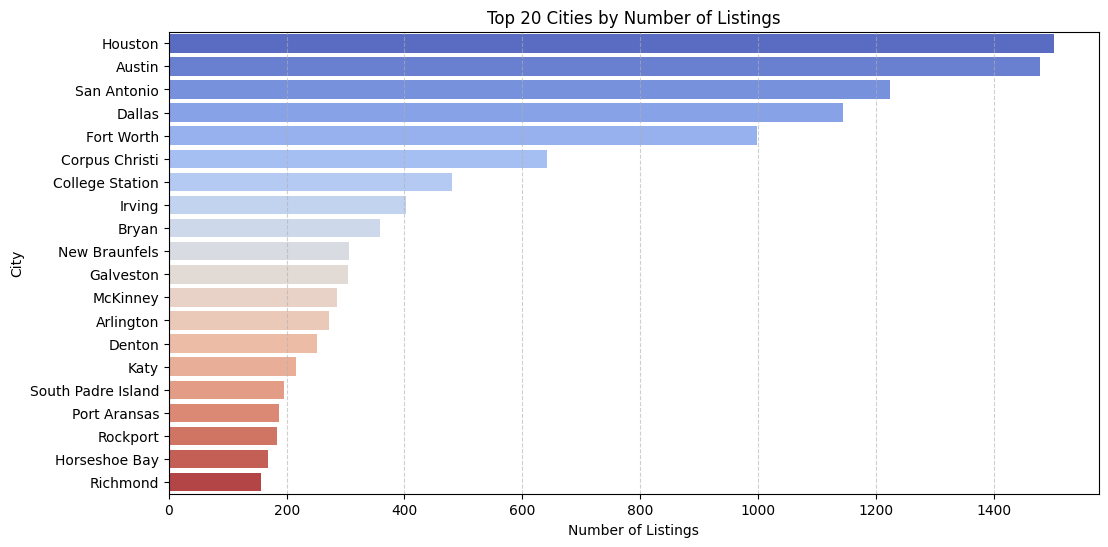

In [ ]:
city_listing_count = df_cleaned["city"].value_counts().reset_index()
city_listing_count.columns = ["city", "num_listings"]

plt.figure(figsize=(12, 6))
sns.barplot(x="num_listings", y="city", data=city_listing_count.head(20), palette="coolwarm")
plt.title("Top 20 Cities by Number of Listings")
plt.xlabel("Number of Listings")
plt.ylabel("City")
plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.show()


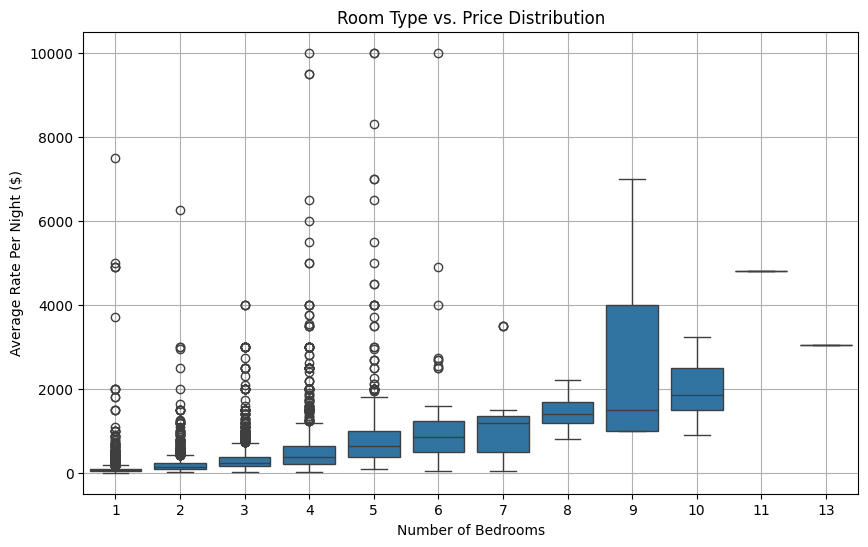

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned["bedrooms_count"], y=df_cleaned["average_rate_per_night"])
plt.title("Room Type vs. Price Distribution")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Average Rate Per Night ($)")
plt.grid(True)
plt.show()


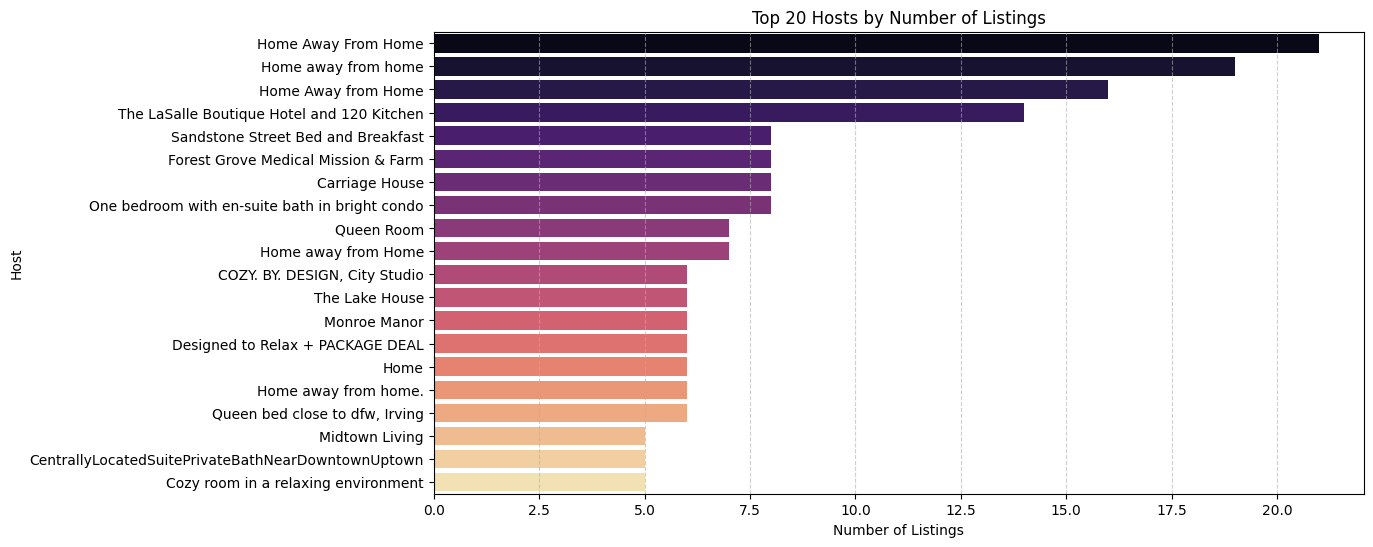

In [ ]:
host_listings_count = df_cleaned["title"].value_counts()
top_hosts = host_listings_count.head(20).reset_index()
top_hosts.columns = ["host", "num_listings"]

plt.figure(figsize=(12, 6))
sns.barplot(x="num_listings", y="host", data=top_hosts, palette="magma")
plt.title("Top 20 Hosts by Number of Listings")
plt.xlabel("Number of Listings")
plt.ylabel("Host")
plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.show()


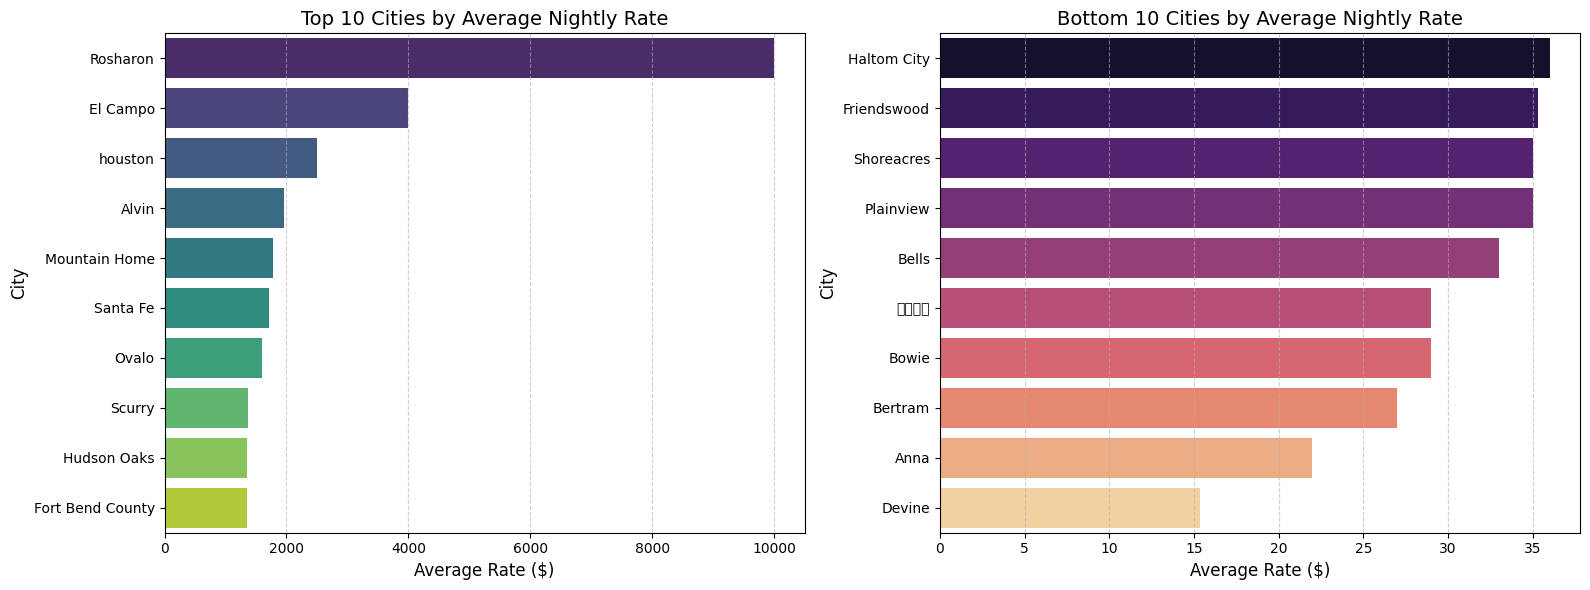

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
city_avg_rate = df_cleaned.groupby("city")["average_rate_per_night"].mean().reset_index()

city_avg_rate = city_avg_rate.sort_values(by="average_rate_per_night", ascending=False)

top_10_cities = city_avg_rate.head(10)
bottom_10_cities = city_avg_rate.tail(10)
sns.barplot(x="average_rate_per_night", y="city", data=top_10_cities, ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 Cities by Average Nightly Rate", fontsize=14)
axes[0].set_xlabel("Average Rate ($)", fontsize=12)
axes[0].set_ylabel("City", fontsize=12)
axes[0].grid(axis='x', linestyle="--", alpha=0.6)

sns.barplot(x="average_rate_per_night", y="city", data=bottom_10_cities, ax=axes[1], palette="magma")
axes[1].set_title("Bottom 10 Cities by Average Nightly Rate", fontsize=14)
axes[1].set_xlabel("Average Rate ($)", fontsize=12)
axes[1].set_ylabel("City", fontsize=12)
axes[1].grid(axis='x', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

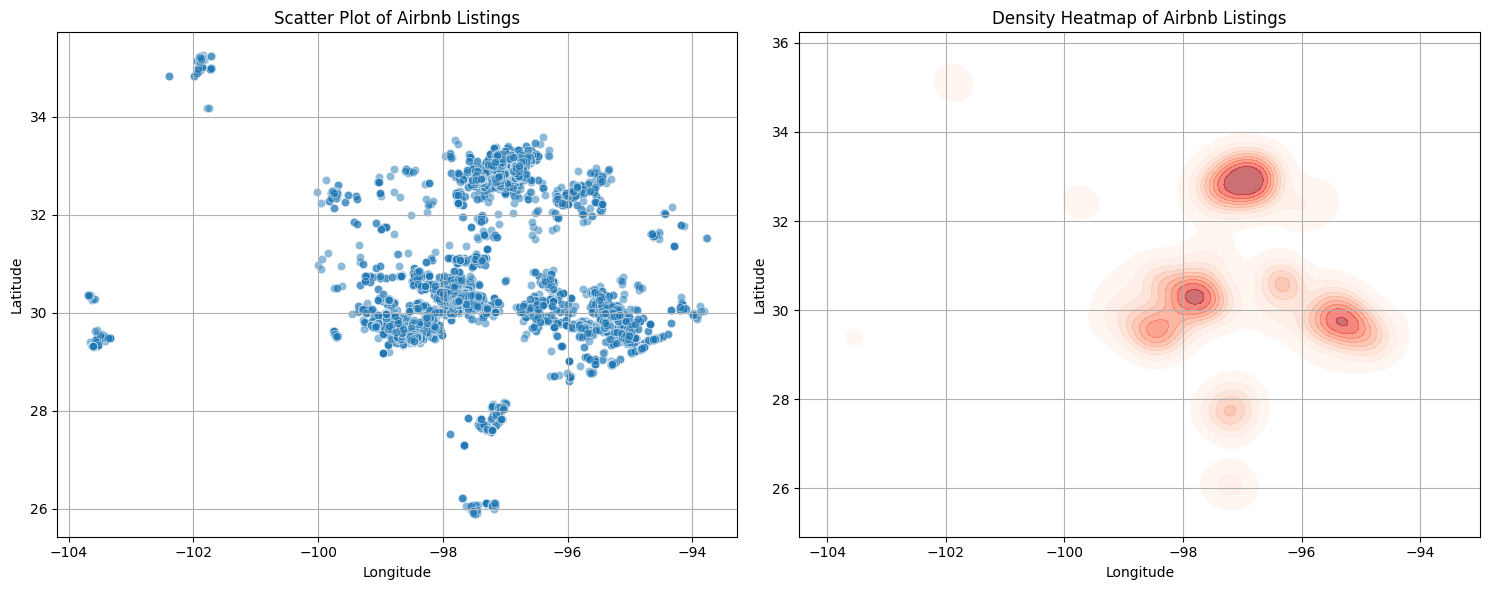

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=df_sample['longitude'], y=df_sample['latitude'], alpha=0.5, ax=axes[0])
axes[0].set_title("Scatter Plot of Airbnb Listings")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(True)

sns.kdeplot(x=df_sample['longitude'], y=df_sample['latitude'], cmap="Reds", fill=True, alpha=0.6, ax=axes[1])
axes[1].set_title("Density Heatmap of Airbnb Listings")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
fig_price_map = px.scatter_mapbox(
    df_cleaned,
    lat="latitude",
    lon="longitude",
    color="average_rate_per_night",
    size=np.sqrt(df_cleaned["average_rate_per_night"]),
    hover_name="city",
    hover_data={"latitude": True, "longitude": True, "average_rate_per_night": True},
    color_continuous_scale="Viridis",
    title="Interactive Price Map of Airbnb Listings",
    zoom=6,
    height=600,
)

fig_price_map.update_layout(mapbox_style="open-street-map")

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_cleaned["cluster"] = kmeans.fit_predict(df_cleaned[["average_rate_per_night"]])


fig_cluster = px.scatter(
    df_cleaned,
    x="longitude",
    y="latitude",
    color=df_cleaned["cluster"].astype(str),
    title="Interactive K-Means Clustering of Airbnb Listings",
    labels={"color": "Cluster"},
    hover_name="city",
    hover_data={"latitude": True, "longitude": True, "average_rate_per_night": True,"city":True},
    height=600,
)

fig_price_map.show()


In [ ]:
fig_cluster.show()

In [ ]:
city_avg_price = df_sample.groupby("city")["average_rate_per_night"].mean().reset_index()

choropleth_map = folium.Map(location=[df_sample['latitude'].mean(), df_sample['longitude'].mean()], zoom_start=6)


for _, row in city_avg_price.iterrows():
    city_data = df_sample[df_sample["city"] == row["city"]]
    if not city_data.empty:
        folium.CircleMarker(
            location=[city_data["latitude"].mean(), city_data["longitude"].mean()],
            radius=np.sqrt(row["average_rate_per_night"]) * 0.3,
            color="green",
            fill=True,
            fill_color="green",
            fill_opacity=0.3,
            popup=f"{row['city']}: ${row['average_rate_per_night']:.2f}",
        ).add_to(choropleth_map)
choropleth_map

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
df_cleaned["description"] = df_cleaned["description"].astype(str).str[:256]

batch_size = 1000
num_batches = len(df_cleaned) // batch_size + 1

sentiments = []

start_time = time.time()

for i in range(num_batches):
    batch = df_cleaned["description"][i * batch_size:(i + 1) * batch_size].tolist()
    if batch:
        results = sentiment_pipeline(batch)
        sentiments.extend([res["label"] for res in results])

    print(f"Processed batch {i + 1}/{num_batches}")

end_time = time.time()
print(f"✅ Sentiment analysis completed in {round(end_time - start_time, 2)} seconds")
df_cleaned["sentiment"] = sentiments

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Processed batch 1/183
Processed batch 2/183
Processed batch 3/183
Processed batch 4/183
Processed batch 5/183
Processed batch 6/183
Processed batch 7/183
Processed batch 8/183
Processed batch 9/183


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed batch 10/183
Processed batch 11/183
Processed batch 12/183
Processed batch 13/183
Processed batch 14/183
Processed batch 15/183
Processed batch 16/183
Processed batch 17/183
Processed batch 18/183
Processed batch 19/183
Processed batch 20/183
Processed batch 21/183
Processed batch 22/183
Processed batch 23/183
Processed batch 24/183
Processed batch 25/183
Processed batch 26/183
Processed batch 27/183
Processed batch 28/183
Processed batch 29/183
Processed batch 30/183
Processed batch 31/183
Processed batch 32/183
Processed batch 33/183
Processed batch 34/183
Processed batch 35/183
Processed batch 36/183
Processed batch 37/183
Processed batch 38/183
Processed batch 39/183
Processed batch 40/183
Processed batch 41/183
Processed batch 42/183
Processed batch 43/183
Processed batch 44/183
Processed batch 45/183
Processed batch 46/183
Processed batch 47/183
Processed batch 48/183
Processed batch 49/183
Processed batch 50/183
Processed batch 51/183
Processed batch 52/183
Processed b

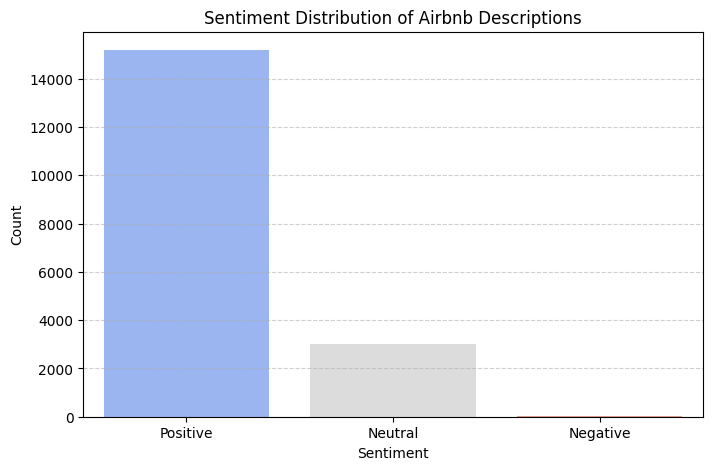

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_cleaned, x="sentiment", palette="coolwarm", order=["LABEL_2", "LABEL_1", "LABEL_0"])
plt.title("Sentiment Distribution of Airbnb Descriptions")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Positive", "Neutral", "Negative"])
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

In [ ]:
city_sentiment = df_cleaned.groupby(["city", "sentiment"]).size().reset_index(name="count")
fig = px.bar(city_sentiment, x="city", y="count", color="sentiment", barmode="group",
             title="Sentiment Analysis by City")
fig.show()

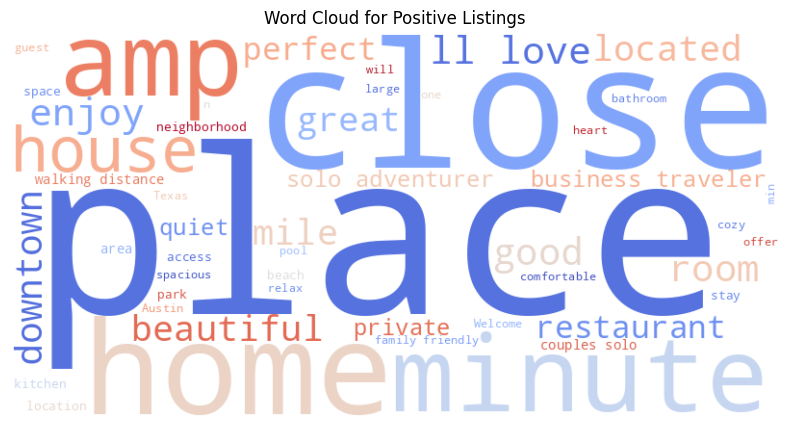

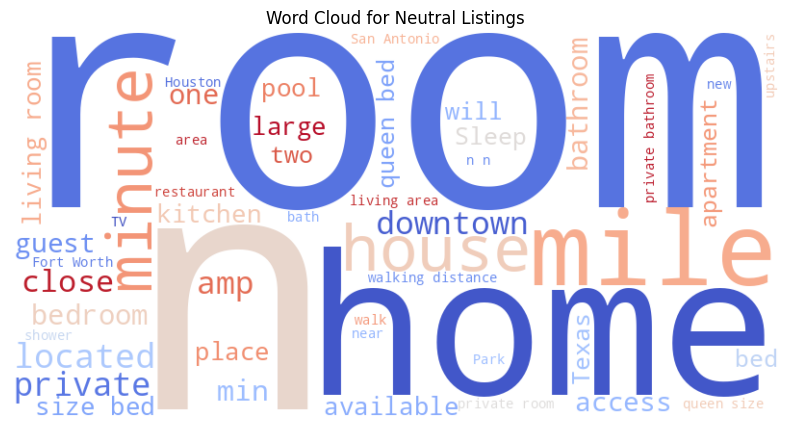

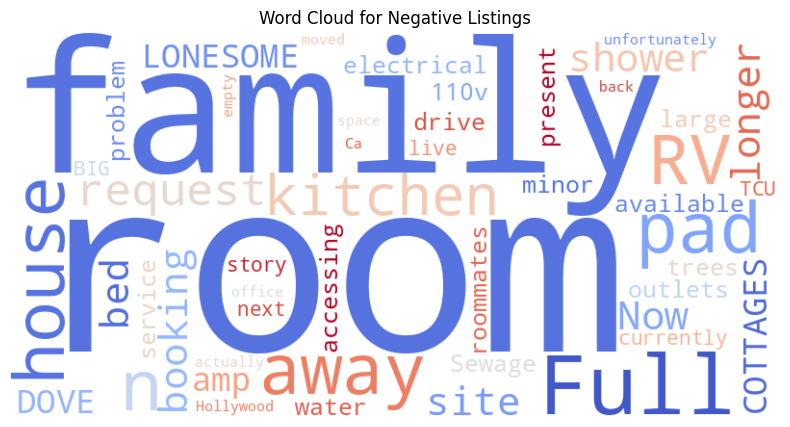

In [ ]:
for sentiment_label, sentiment_name in zip(["LABEL_2", "LABEL_1", "LABEL_0"], ["Positive", "Neutral", "Negative"]):
    sentiment_text = " ".join(df_cleaned[df_cleaned["sentiment"] == sentiment_label]["description"].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white",
                      colormap="coolwarm",
                      max_words=50, random_state=42).generate(sentiment_text)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment_name} Listings")
    plt.show()

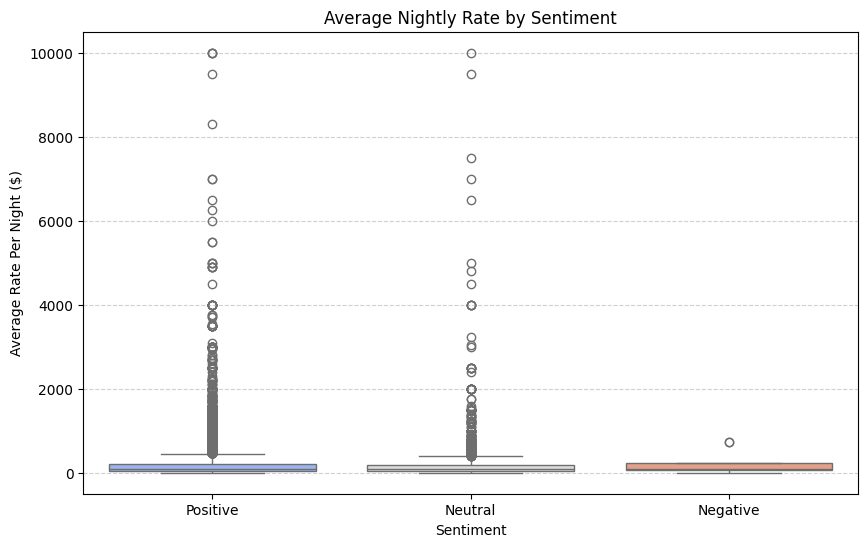

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x="sentiment", y="average_rate_per_night", order=["LABEL_2", "LABEL_1", "LABEL_0"], palette="coolwarm")
plt.title("Average Nightly Rate by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Rate Per Night ($)")
plt.xticks(ticks=[0, 1, 2], labels=["Positive", "Neutral", "Negative"])
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()